## 0. Imports, Paths and Helper Functions

### 0.1 Imports

In [1]:
import json
import psycopg2
import itertools
import pickle


import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

import scikitplot as skplt
import sklearn.model_selection as ms

from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler,MinMaxScaler
from sklearn.tree          import DecisionTreeClassifier, ExtraTreeClassifier

from scipy                 import stats        as ss
from sklearn               import neighbors    as nh
from sklearn               import linear_model as lm


### 0.2 Paths

In [2]:
data = '../data/'
raw  = 'raw/'
interim = 'interim/'
processed = 'processed/'

modules_path = '../models/'

images_path = '../reports/figures/'

### 0.3 Helper Functions

In [3]:
def create_ranking(model, data, selected_cols, target):
    x_train = data[selected_cols]
    y_train = data[target]
    
    probas = model.predict_proba(x_train)
    
    data['score'] = probas[:,1].tolist()
    data = data.sort_values('score',ascending=False)
    data = data.reset_index(drop=True)
    
    data['ranking'] = data.index+1
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()
    
    return data
    

def cross_validation(kfold, at_k, model, data,target,cols_selected):
    
    folds = ms.StratifiedKFold(n_splits=kfold,shuffle=True,random_state=42)
    
    precision = []
    recall = []
    
    for train_index, test_index in folds.split(data,data[target]):
        
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        
        #train and test model - return model probas
        yhat_model = model_evaluation(train,test,model,cols_selected,target)
        
        df_score = test.copy()
        df_score['score'] = yhat_model[:,1].tolist()
        df_score = df_score.sort_values('score',ascending=False)
        
        precision_model = precision_at_k(df_score,at_k)
        recall_model = recall_at_k(df_score,at_k)
        
        precision.append(precision_model)
        recall.append(recall_model)

    mean_p = np.mean(precision)
    std_p = np.std(precision)
    
    mean_r = np.mean(recall)
    std_r = np.std(recall)
    
    return mean_p, std_p, mean_r, std_r


def precision_at_k(data, k=5000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index+1

    #computing precision at k score
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']
    precision_at_k = data.loc[k,'precision_at_k']
    
    return precision_at_k


def recall_at_k(data, k=5000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index+1

    #computing recall at k score
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()
    recall_at_k = data.loc[k,'recall_at_k']
    
    return recall_at_k


def model_evaluation(train,test,model,cols_selected,target):
    x_train = train[cols_selected]
    y_train = train[target]
    
    x_test = test[cols_selected]
    
    model.fit(x_train,y_train)
    
    yhat_model = model.predict_proba(x_test)
    
    return yhat_model

def gmc(y_true,y_probas, model_name):
    figs,ax = plt.subplots(ncols=3,figsize=(20,5))
    
    skplt.metrics.plot_roc(y_true,y_probas, ax=ax[0],title=f"ROC - {model_name}")
    skplt.metrics.plot_cumulative_gain(y_true,y_probas, ax=ax[1],title=f"Cumulative Gain - {model_name}")
    skplt.metrics.plot_lift_curve(y_true,y_probas, ax=ax[2],title=f"Lift Curve - {model_name}")
    
    plt.show()


def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v


def categorical_feature_correlation(df_cat):
    cat_list = df_cat.columns.to_list()
    dic_corr = {cat : [] for cat in cat_list}
    
    for a,b in itertools.product(cat_list,repeat=2):
        dic_corr[a].append(cramer_v(df_cat[a],df_cat[b]))

    return pd.DataFrame(dic_corr,index=cat_list)


def cat_info(ax,total,size = 25,file=False):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(height/total*100),
                ha="center",size=size) 
    plt.show()
    
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 10.0 Business Answers

In [5]:
selected_cols = ['vintage',
                 'annual_premium',
                 'age',
                 'vehicle_damage',
                 'region_code',
                 'policy_sales_channel']

In [6]:
train = pd.read_csv(data+processed+'train_processed.csv')
test = pd.read_csv(data+interim+'test.csv')
validation = pd.read_csv(data+processed+'validation_processed.csv')

In [7]:
total = len(train)+len(validation)+len(test)
len(train)/total,len(validation)/total, len(test)/total, len(train),len(validation),len(test)


(0.6399980058198573,
 0.20000052478424807,
 0.1600014693958946,
 243909,
 76222,
 60978)

In [8]:
ab_model = pickle.load(open(modules_path+'ab_model.pkl','rb'))

### 10.1 Avg call costs and insurance profits

In [9]:
cost_per_call = 3.14
total_calls  = [20000,40000]
insurance_price_annual = 1577.86

### 10.2 Baseline - Random Model

In [10]:
index_clients = validation.index.copy()
chosen_clients = np.random.choice(index_clients,total_calls[0])

selected_clients = validation.iloc[chosen_clients]
interested = recall_at_k(validation,total_calls[0])

call_cost_20k = cost_per_call * total_calls[0]

profit_20k = selected_clients['response'].sum() * interested * insurance_price_annual



print(f'20k Calls: Calling at random, the offer would be reach {100*interested:.2f}% of the interested clients, granting an income of R${profit_20k-call_cost_20k:.2f}.')

20k Calls: Calling at random, the offer would be reach 26.65% of the interested clients, granting an income of R$1010385.58.


In [11]:
index_clients = validation.index.copy()
chosen_clients = np.random.choice(index_clients,total_calls[1])

selected_clients = validation.iloc[chosen_clients]
interested = recall_at_k(validation,total_calls[1])

call_cost_40k = cost_per_call * total_calls[1]
profit_40k = selected_clients['response'].sum() * interested * insurance_price_annual

print(f'40k Calls: Calling at random, the offer would be reach {100*interested:.2f}% of the interested clients, granting an income of R${profit_40k-call_cost_40k:.2f}.')

40k Calls: Calling at random, the offer would be reach 52.95% of the interested clients, granting an income of R$3937464.66.


### 10.3 Validation - Calls on Model's Ranked List

In [12]:
clients_test = validation.copy()
clients_test = create_ranking(ab_model,clients_test,selected_cols,'response')

In [13]:
yhat = ab_model.predict_proba(clients_test[selected_cols])

In [14]:
interested_20k = float(clients_test['recall_at_k'].iloc[20000])
interested_40k = float(clients_test['recall_at_k'].iloc[40000])

profit_20k = clients_test['response'].sum() * interested_20k * insurance_price_annual
profit_40k = clients_test['response'].sum() * interested_40k * insurance_price_annual


print(f'20k Calls - Calling at ranked list, the offer would be reach {100*interested_20k:.2f} % of the interested clients, granting an income of R${profit_20k:.2f}.')
print(f'40k Calls - Calling at ranked list, the offer would be reach {100*interested_40k:.2f} % of the interested clients, granting an income of R${profit_40k:.2f}.')

20k Calls - Calling at ranked list, the offer would be reach 86.33 % of the interested clients, granting an income of R$12782243.86.
40k Calls - Calling at ranked list, the offer would be reach 97.22 % of the interested clients, granting an income of R$14394816.78.


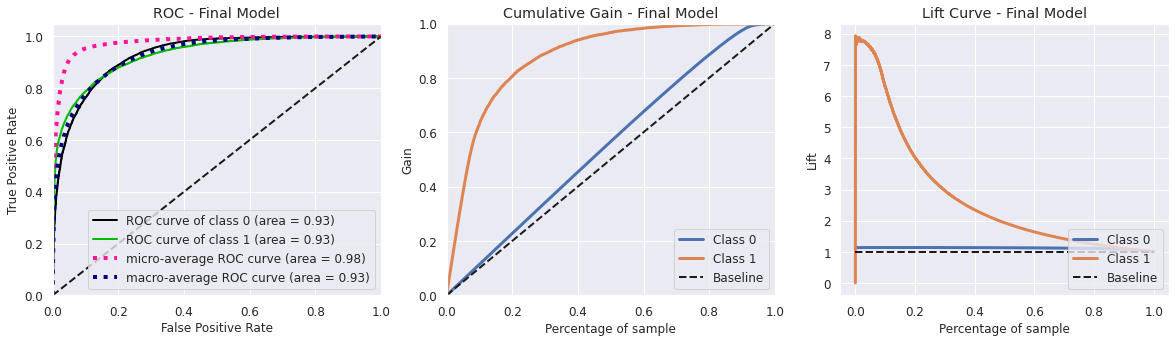

In [15]:
gmc(clients_test['response'],yhat,'Final Model')

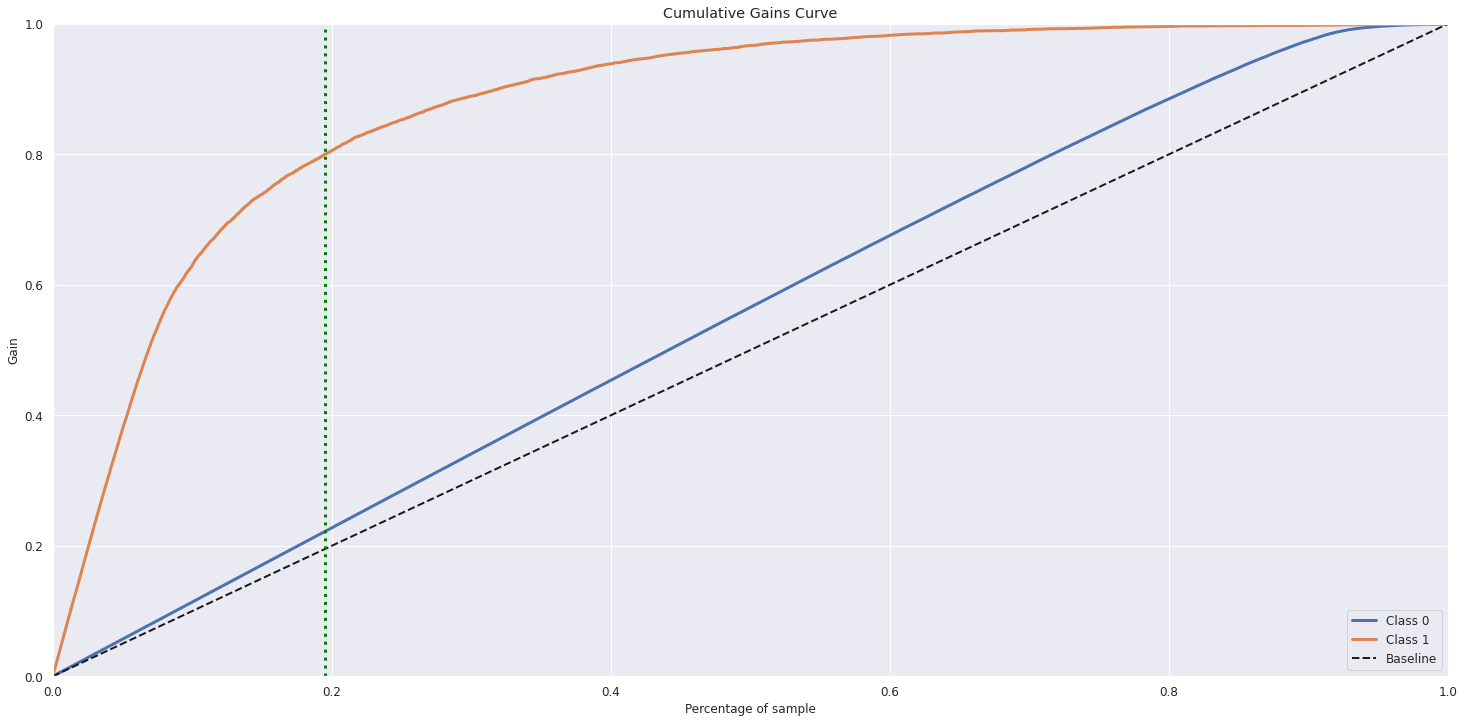

In [16]:
data_percent = len(clients_test[clients_test['recall_at_k'] <= 0.8])/len(clients_test)
skplt.metrics.plot_cumulative_gain(clients_test['response'],yhat)
plt.axvline(data_percent,0,1,color='green',ls=':',lw=3)

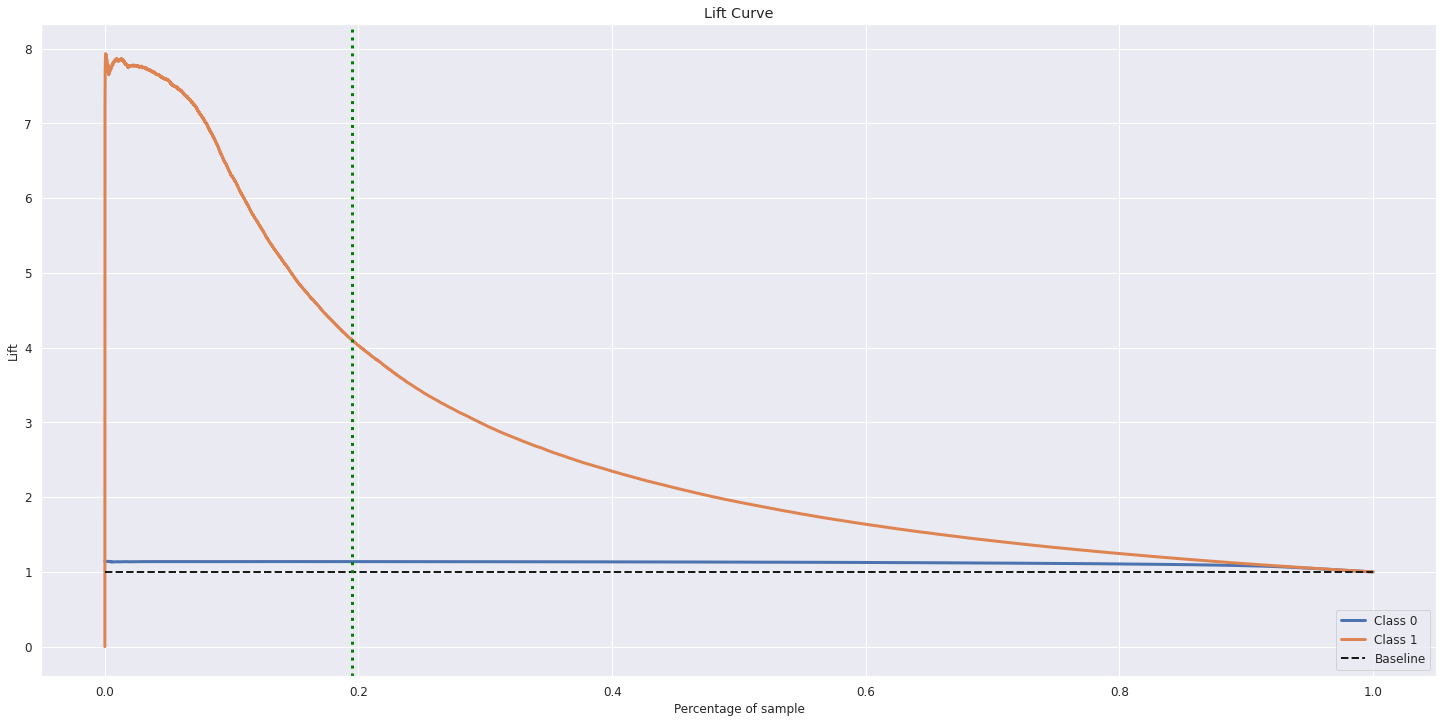

In [17]:
skplt.metrics.plot_lift_curve(clients_test['response'],yhat)
plt.axvline(data_percent,0,1,color='green',ls=':',lw=3)

In [18]:
data_percent

0.19514051061373358

With 19.51% of the validation data, the calls can reach 80% of interested clients.

### 10.4 Generalization Test

### 10.4.1 - Encoding test data

In [19]:
age_scaler =pickle.load(open(modules_path+'age_scaler.pkl','rb'))
annual_premium_scaler = pickle.load(open(modules_path+'annual_premium_scaler.pkl','rb'))
vintage_scaler = pickle.load(open(modules_path+'vintage_scaler.pkl','rb'))

policy_sales_channel_encoder = pickle.load(open(modules_path+'policy_sales_channel_encoder.pkl','rb'))
region_code_encoder = pickle.load(open(modules_path+'region_code_encoder.pkl','rb'))
vehicle_age_encoder = pickle.load(open(modules_path+'vehicle_age_encoder.pkl','rb'))
gender_encoder = {'male':0,'female':1}


In [20]:
test['age'] = age_scaler.transform(test[['age']].values)
test['annual_premium'] = annual_premium_scaler.transform(test[['annual_premium']].values)
test['vintage'] = vintage_scaler.transform(test[['vintage']].values)

test.loc[:,'gender'] = test['gender'].map(gender_encoder)
test.loc[:,'region_code'] = test['region_code'].map(region_code_encoder)
test.loc[:,'vehicle_age'] = test['vehicle_age'].map(vehicle_age_encoder)
test.loc[:,'policy_sales_channel'] = test['policy_sales_channel'].map(policy_sales_channel_encoder)

test.fillna(0,inplace=True)

In [21]:
test.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

### 10.4.2- Random Calls on Test data

In [32]:
index_clients = test.index.copy()
chosen_clients = np.random.choice(index_clients,total_calls[0])

selected_clients = test.iloc[chosen_clients]
interested = recall_at_k(test,total_calls[0])

call_cost_20k = cost_per_call * total_calls[0]

profit_20k = selected_clients['response'].sum() * interested * insurance_price_annual

print(f'20k Calls: Calling at random, the offer would be reach {100*interested:.2f}% of the interested clients, granting an income of R${profit_20k-call_cost_20k:.2f}.')

20k Calls: Calling at random, the offer would be reach 33.14% of the interested clients, granting an income of R$1231314.93.


In [34]:
index_clients = test.index.copy()
chosen_clients = np.random.choice(index_clients,total_calls[1])

selected_clients = test.iloc[chosen_clients]
interested = recall_at_k(test,total_calls[1])

call_cost_40k = cost_per_call * total_calls[1]

profit_40k = selected_clients['response'].sum() * interested * insurance_price_annual

print(f'40k Calls: Calling at random, the offer would be reach {100*interested:.2f}% of the interested clients, granting an income of R${profit_40k-call_cost_40k:.2f}.')

40k Calls: Calling at random, the offer would be reach 66.41% of the interested clients, granting an income of R$5015144.71.


### 10.4.3 - Model applied on Test Data

In [22]:
test_ranked = create_ranking(ab_model, test.copy(),selected_cols,'response')
yhat_test = ab_model.predict_proba(test[selected_cols])

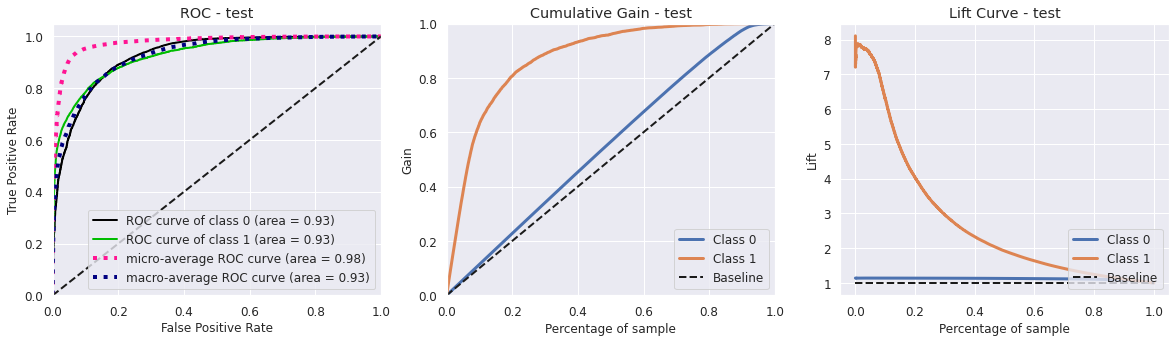

In [23]:
gmc(test['response'],yhat_test,'test')

#### 10.4.3.1 20.000 Calls in Test group

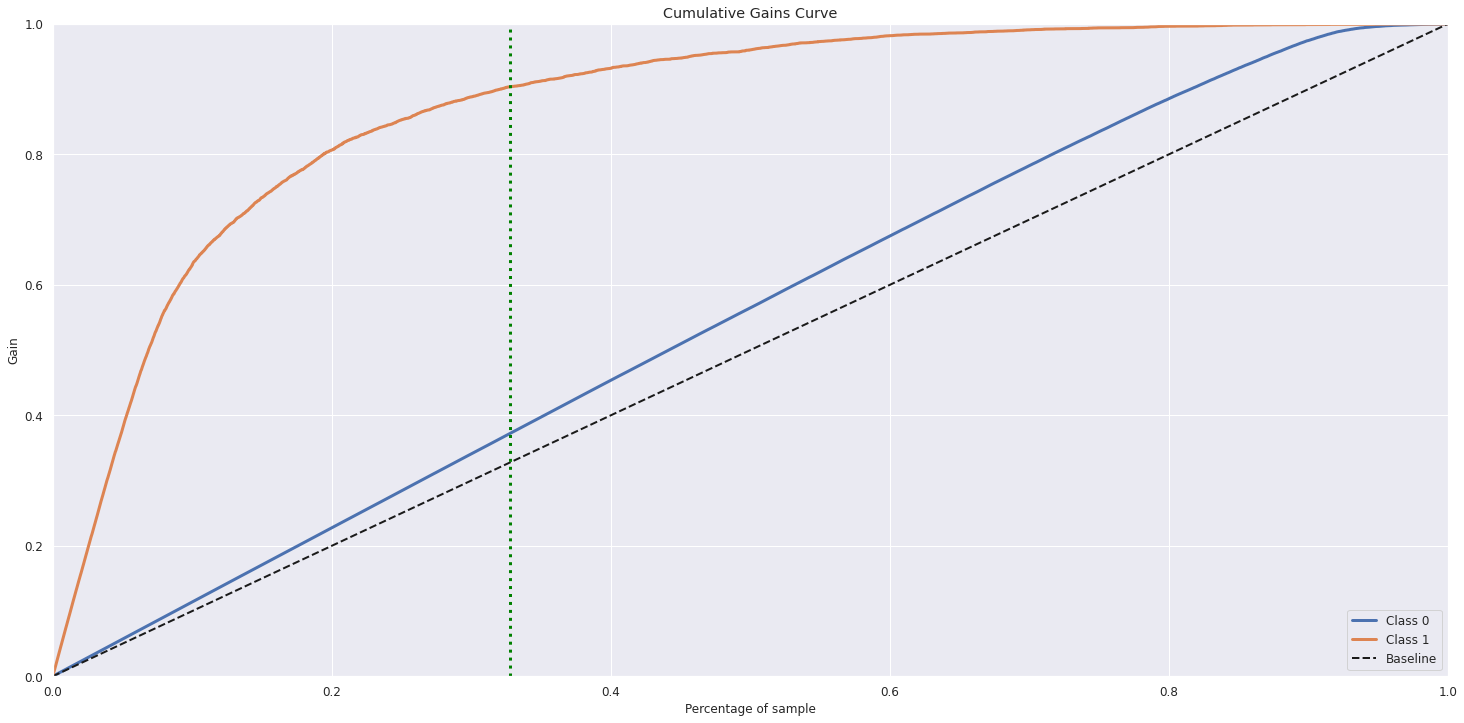

In [24]:
test_percent = total_calls[0]/test_ranked.shape[0]
skplt.metrics.plot_cumulative_gain(test['response'],yhat_test)
plt.axvline(test_percent,0,1,color='green',ls=':',lw=3)

In [25]:
test_interested_20k = test_ranked['recall_at_k'].iloc[20000]
test_profit_20k = test_ranked['response'].sum()*test_ranked['recall_at_k'].iloc[20000]*insurance_price_annual

print(f"20k Calls: Calling at ranked list, the offer would be reach {test_interested_20k*100:.2f}%, granting a revenue of R$ {test_profit_20k:.2f} ")

20k Calls: Calling at ranked list, the offer would be reach 90.40%, granting a revenue of R$ 10721558.70 


#### 10.4.3.2 40000 Calls in the test group

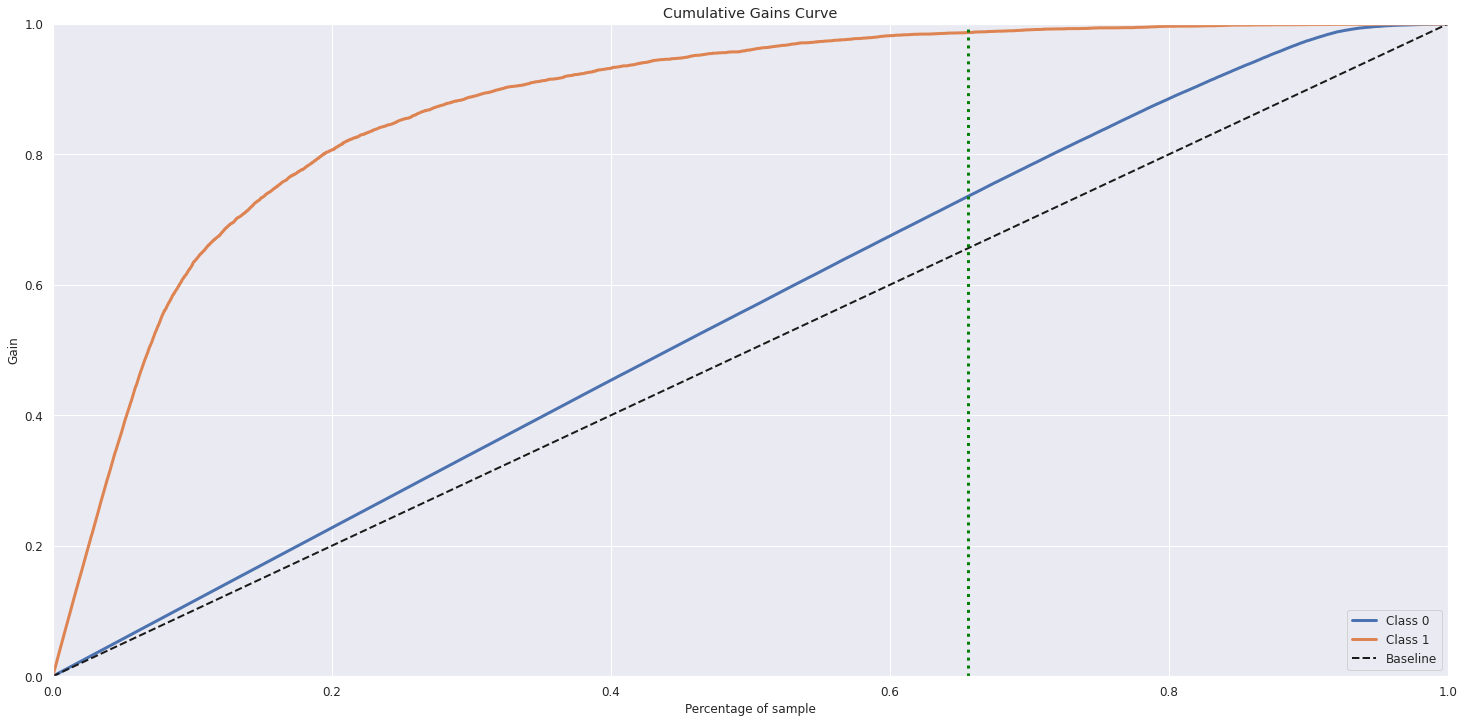

In [26]:
test_percent = total_calls[1]/test_ranked.shape[0]
skplt.metrics.plot_cumulative_gain(test['response'],yhat_test)
plt.axvline(test_percent,0,1,color='green',ls=':',lw=3)

In [27]:
test_interested_40k = test_ranked['recall_at_k'].iloc[40000]
test_profit_40k = test_ranked['response'].sum()*test_ranked['recall_at_k'].iloc[40000]*insurance_price_annual

print(f"40k Calls: Calling at ranked list, the offer would be reach {test_interested_40k*100:.2f}%, granting a revenue of R$ {test_profit_40k:.2f} ")

40k Calls: Calling at ranked list, the offer would be reach 98.68%, granting a revenue of R$ 11704565.48 


#### 10.4.3.3 80% of all interested

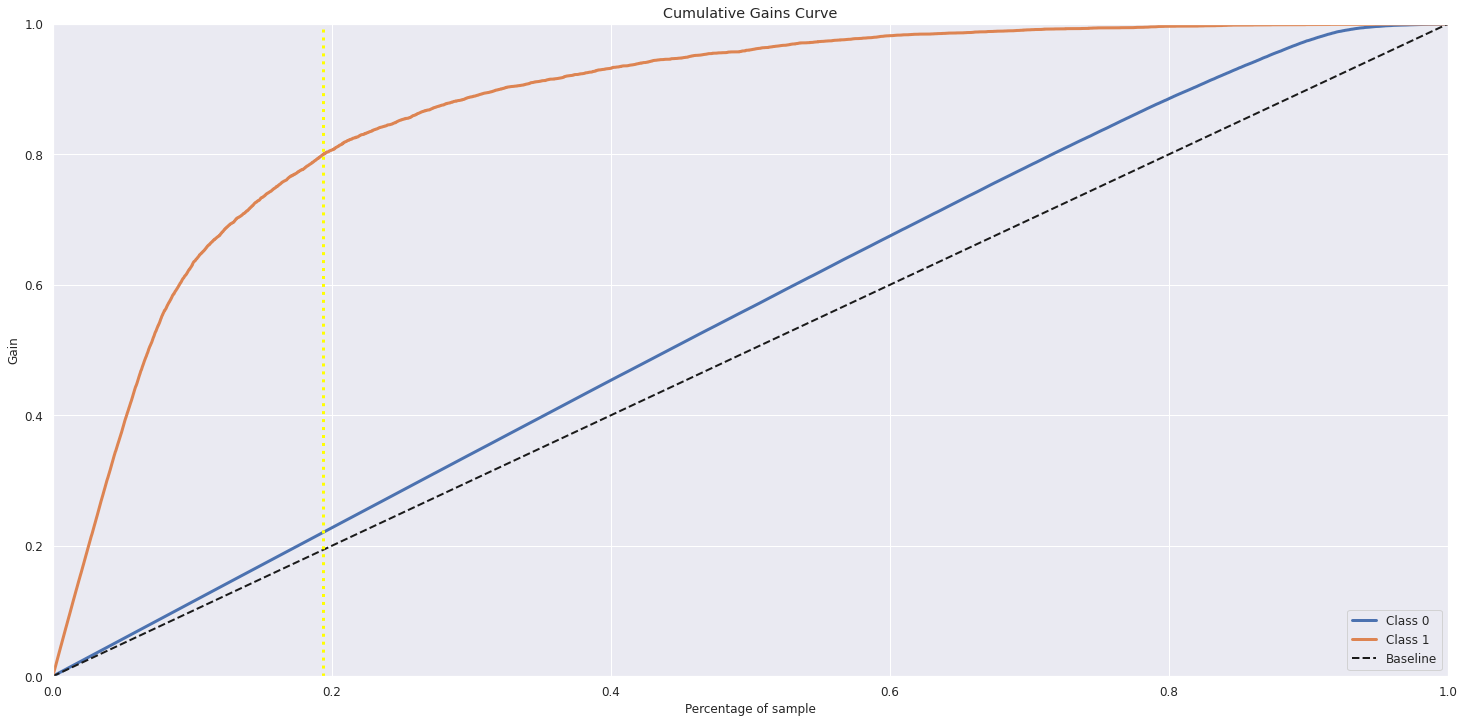

In [28]:
test_percent_80 = len(test_ranked[test_ranked['recall_at_k'] <= 0.8])/test_ranked.shape[0]
skplt.metrics.plot_cumulative_gain(test['response'],yhat_test)
plt.axvline(test_percent_80,0,1,color='yellow',ls=':',lw=3)

In [29]:
data_percent = len(test_ranked[test_ranked['recall_at_k'] <= 0.8])/len(test_ranked)
data_percent

0.1939879956705697

With 19.39% of the test data, we can reach 80% of the interested clients.

### 10.5 - Expected Income for 127k Clients

In [30]:
test.value_counts('response',normalize=True)

response
0    0.876726
1    0.123274
dtype: float64

In [31]:
new_income_20k = (127000*(12.32/100)*test_ranked['recall_at_k'].iloc[20000]*insurance_price_annual - cost_per_call*total_calls[0])
new_income_40k = (127000*(12.32/100)*test_ranked['recall_at_k'].iloc[40000]*insurance_price_annual - cost_per_call*total_calls[1])

print(f'20k Calls: R${new_income_20k:.2f}'.format())
print(f'40k Calls: R${new_income_40k:.2f}'.format())

20k Calls: R$22253788.54
40k Calls: R$24237086.35


Assumindo que os clientes tenham o mesmo comportamento observado nos datasets de treino, validação e teste (approx. 12,32% de aceitação) na compra do seguro, é esperado que a companhia gere uma receita bruta de:

* 20 mil ligações: R$ 25.247.646,43

* 40 mil ligações: R$ 27.544.312,17